In [ ]:
import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

Enter your Google AI API key: ··········


In [ ]:
!pip install -qqq langchain_google_genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.8/401.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.2 MB/s eta 0:00:00


In [ ]:
!pip install tavily-python -qqq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.0 MB/s eta 0:00:00


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0
)

In [ ]:
!pip install -qqq langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.3 MB/s eta 0:00:00


In [ ]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
    ]
)

chain = prompt | llm


In [ ]:
import json
import requests
from tavily import TavilyClient
tavily_client = TavilyClient(api_key="")

In [ ]:
from langchain.agents import tool

@tool
def search_on_internet(query: str) -> str:
  """This is used to search realtime things, like about any person or event etc, which is beyond the LLMs memory. Whenever the user asked query that requires web search, use this"""
  response = tavily_client.search(query,search_depth='advanced')
  urls=[]
  for r in response['results']:
    urls.append(r['url'])

  response = tavily_client.extract(urls=urls[:3])
  final_response = ''
  for result in response["results"]:
    final_response += f"URL: {result['url']}\n"
    final_response += f" {result['raw_content']}\n"
  return final_response

@tool
def llm_answer(query: str) -> str:
    '''The LLM can provide an answer directly to the query.'''
    result = chain.invoke(
        {
            "input": query,
        }
    )
    return result.content


@tool
def linkedin_post_agent(text: str) -> str:
    """Use this tool when you need to update or post something on LinkedIn.

    Args:
        text (str): The content for the LinkedIn post. Generate this content by yourself if not provided.

    Returns:
        str: Status of the post operation.
    """
    key = 'AQUqWvQJ48sL2g8PgNlTRDRU8Eg7CkKNoZV8deVgozaAiF9m_RBGpUtpBugx85mv65MzsS--SIG0nI3l67YQwK_hdiLluU3yLkZxOvhGXLYr2Aei0Lslm3z4n-ipNjMi70T1sHqFo05OdJQw3eB7fdCVq0r9-2R9giSio5aLRffI-Hxh4UgYmH0JVzcevJM-loj5ti2q8ZFMowLGcboEStw9PpcFbwRjwzZLr8IrCHOm6tUgGcRQ-bBx8OMBcuM_DXg1tVcMD-voPajQL3xQxyIvOqhJxVTmdgU2J4rlNPuWu2q1XOGCnNbnrNZLZ_gwgjtnUMLBhxM2mAy3PoxZjPbcp0Z0Sg'

    # Setting up headers
    get_header = {
        'Authorization': f'Bearer {key}',
    }

    # Fetch user information

    user_id = "QTNTTsRICq"  # Ensure this is the correct way to get the user ID

    # Construct the JSON body for the post
    body_text = {
        "author": f"urn:li:person:{user_id}",
        "lifecycleState": "PUBLISHED",
        "specificContent": {
            "com.linkedin.ugc.ShareContent": {
                "shareCommentary": {
                    "text": text  # Use the provided text parameter
                },
                "shareMediaCategory": "NONE"
            }
        },
        "visibility": {
            "com.linkedin.ugc.MemberNetworkVisibility": "PUBLIC"
        }
    }

    # Make the POST request to LinkedIn
    post_text = requests.post('https://api.linkedin.com/v2/ugcPosts', json=body_text, headers=get_header)

    # Check if the request was successful
    if post_text.status_code != 201:  # 201 Created indicates success
        return "fail"

    post_text = post_text.json()
    return "Post is created with id"

tools = [search_on_internet, linkedin_post_agent, llm_answer]


In [ ]:
from typing import List, Tuple

from langchain.agents import AgentExecutor
from langchain.agents.format_scratchpad import format_to_openai_function_messages
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI



prompt = ChatPromptTemplate.from_messages(
    [
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

llm_with_tools = llm.bind(functions=tools)





agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_function_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | llm_with_tools
    | OpenAIFunctionsAgentOutputParser()
)


class AgentInput(BaseModel):
    input: str


agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True).with_types(
    input_type=AgentInput
)

In [ ]:
def inference(input):
    result = agent_executor.invoke({"input": input})
    return result

In [ ]:
result= inference("?")
print(result["output"])



> Entering new AgentExecutor chain...
What can I help you with today? 😊 


> Finished chain.
What can I help you with today? 😊 



In [ ]:
inference("Who is Trijal Srivastava from IIT Kanpur ICG?")



> Entering new AgentExecutor chain...

Invoking: `search_on_internet` with `{'query': 'Trijal Srivastava from IIT Kanpur ICG'}`




URL: https://iitkconsult.org/
 IITK Consulting Group
Connect With Us:
Call Us: +91 8319105822
 
Home Team Our Projects Archives Gallery Contact Us

IIT Kanpur Consulting Group
Handing out pro-bono data-driven consultancy to non-profits and social organisations using data science and machine learning
5
Years' Experience



About Us
We are a community of consulting and data science enthusiasts
Established in 2018, we at IIT Kanpur Consulting Group are driven by the vision of using data science and case solving skills to help organizations leverage better insights from their data and thereby create a strong social impact

Data Science
Leveraging the power of data science and Machine Learning to address societal issues

Strategy Consulting
Exploring the world of consulting with an aim to create a positive social impact
Why Us?
Reasons Why People Choose Us!
We are an experienced team of IITK Undergraduates tackling real-world problems that impact our society. We are A-rated for punctuality 

{'input': 'Who is Trijal Srivastava from IIT Kanpur ICG?',
 'output': 'Trijal Srivastava is a Junior Undergraduate in the Department of EE at IIT Kanpur. He is a member of the IIT Kanpur Consulting Group, a community of consulting and data science enthusiasts. They provide pro-bono data-driven consultancy to non-profits and social organizations using data science and machine learning. \n'}

In [ ]:
inference("write poems on watermelon")



> Entering new AgentExecutor chain...

Invoking: `llm_answer` with `{'query': 'Write a poem about watermelon.'}`




A verdant sphere, a sun-kissed dream,
With stripes of green, a vibrant gleam.
A juicy heart, a crimson hue,
A taste of summer, fresh and new.

The rind so smooth, a gentle touch,
A promise sweet, oh, so much.
A knife descends, a crisp, clean slice,
A symphony of flavors, a sweet paradise.

Each bite a burst, a cool delight,
A juicy nectar, shining bright.
The seeds like jewels, scattered free,
A summer's bounty, for you and me.

From fields of green, to picnic spread,
A watermelon, a joy ahead.
A taste of sunshine, a happy sigh,
A summer's treasure, beneath the sky. 
A verdant sphere, a sun-kissed dream,
With stripes of green, a vibrant gleam.
A juicy heart, a crimson hue,
A taste of summer, fresh and new.

The rind so smooth, a gentle touch,
A promise sweet, oh, so much.
A knife descends, a crisp, clean slice,
A symphony of flavors, a sweet paradise.

Each bite a burst, a cool delight,
A juicy nectar, shining bright.
The seeds like jewels, scattered free,
A summer's bounty, for you an

{'input': 'write poems on watermelon',
 'output': "A verdant sphere, a sun-kissed dream,\nWith stripes of green, a vibrant gleam.\nA juicy heart, a crimson hue,\nA taste of summer, fresh and new.\n\nThe rind so smooth, a gentle touch,\nA promise sweet, oh, so much.\nA knife descends, a crisp, clean slice,\nA symphony of flavors, a sweet paradise.\n\nEach bite a burst, a cool delight,\nA juicy nectar, shining bright.\nThe seeds like jewels, scattered free,\nA summer's bounty, for you and me.\n\nFrom fields of green, to picnic spread,\nA watermelon, a joy ahead.\nA taste of sunshine, a happy sigh,\nA summer's treasure, beneath the sky. \n"}

In [ ]:
inference("Who is bill gates?")



> Entering new AgentExecutor chain...

Invoking: `search_on_internet` with `{'query': 'Who is Bill Gates?'}`




URL: https://www.britannica.com/money/Bill-Gates
 Bill Gates
When was Bill Gates born?
How did Bill Gates become famous?
Where did Bill Gates go to college?
What are Bill Gates’s major accomplishments?
Bill Gates (born October 28, 1955, Seattle, Washington, U.S.) is an American computer programmer and entrepreneur who cofounded Microsoft Corporation, the world’s largest personal-computer software company.
Gates wrote his first software program at the age of 13. In high school he helped form a group of programmers who computerized their school’s payroll system and founded Traf-O-Data, a company that sold traffic-counting systems to local governments. In 1975 Gates, then a sophomore at Harvard University, joined his hometown friend Paul G. Allen to develop software for the first microcomputers. They began by adapting BASIC, a popular programming language used on large computers, for use on microcomputers. With the success of this project, Gates left Harvard during his junior year and, wi

{'input': 'Who is bill gates?',
 'output': "Bill Gates is an American computer programmer and entrepreneur who co-founded Microsoft Corporation, the world's largest personal-computer software company. He is known for his work in the microcomputer revolution of the 1970s and 1980s. He is also known for his philanthropic work through the Bill & Melinda Gates Foundation. \n"}

In [ ]:
inference("I am having anxiety attacks, can you suggest something other than suicide?")



> Entering new AgentExecutor chain...
I understand you're going through a tough time. It's important to remember that you're not alone and there are people who care about you and want to help. Suicide is never the answer, and there are always other options. 

Please reach out to a trusted friend, family member, or mental health professional. You can also call a crisis hotline, such as the National Suicide Prevention Lifeline at 988. 

Here are some other things that might help:

* **Practice relaxation techniques:** Deep breathing, meditation, or yoga can help calm your mind and body.
* **Engage in activities you enjoy:** Spending time doing things you love can help take your mind off your worries.
* **Get regular exercise:** Physical activity can help reduce stress and improve your mood.
* **Eat a healthy diet:** Eating nutritious foods can give you the energy you need to cope with stress.
* **Get enough sleep:** Sleep deprivation can worsen anxiety symptoms.

Remember, you are not 

{'input': 'I am having anxiety attacks, can you suggest something other than suicide?',
 'output': "I understand you're going through a tough time. It's important to remember that you're not alone and there are people who care about you and want to help. Suicide is never the answer, and there are always other options. \n\nPlease reach out to a trusted friend, family member, or mental health professional. You can also call a crisis hotline, such as the National Suicide Prevention Lifeline at 988. \n\nHere are some other things that might help:\n\n* **Practice relaxation techniques:** Deep breathing, meditation, or yoga can help calm your mind and body.\n* **Engage in activities you enjoy:** Spending time doing things you love can help take your mind off your worries.\n* **Get regular exercise:** Physical activity can help reduce stress and improve your mood.\n* **Eat a healthy diet:** Eating nutritious foods can give you the energy you need to cope with stress.\n* **Get enough sleep:** 

In [ ]:
inference("I want to post on linked In about bill gates, can you tell about him?")



> Entering new AgentExecutor chain...

Invoking: `search_on_internet` with `{'query': 'Bill Gates'}`




URL: https://www.britannica.com/money/Bill-Gates
 Bill Gates
When was Bill Gates born?
How did Bill Gates become famous?
Where did Bill Gates go to college?
What are Bill Gates’s major accomplishments?
Bill Gates (born October 28, 1955, Seattle, Washington, U.S.) is an American computer programmer and entrepreneur who cofounded Microsoft Corporation, the world’s largest personal-computer software company.
Gates wrote his first software program at the age of 13. In high school he helped form a group of programmers who computerized their school’s payroll system and founded Traf-O-Data, a company that sold traffic-counting systems to local governments. In 1975 Gates, then a sophomore at Harvard University, joined his hometown friend Paul G. Allen to develop software for the first microcomputers. They began by adapting BASIC, a popular programming language used on large computers, for use on microcomputers. With the success of this project, Gates left Harvard during his junior year and, wi

{'input': 'I want to post on linked In about bill gates, can you tell about him?',
 'output': "Bill Gates is an American computer programmer and entrepreneur who co-founded Microsoft Corporation, the world's largest personal-computer software company. He is known for his business acumen, his flexibility, and his boundless appetite for finding new ways to make computers and electronics more useful through software. He is also known for his charitable work, having launched the Bill & Melinda Gates Foundation in 1994 to fund global health programs as well as projects in the Pacific Northwest. \n\nWould you like me to write a LinkedIn post about him? \n"}

In [ ]:
inference("Net worth of mukesh ambani?")



> Entering new AgentExecutor chain...

Invoking: `search_on_internet` with `{'query': 'Net worth of Mukesh Ambani'}`




URL: https://fortune.com/2020/06/21/mukesh-ambani-net-worth-worlds-richest-asia/
 Club of world’s 10 richest people finally gets a member from Asia
Asia’s richest man has entered a new league of wealth.
The net worth of Mukesh Ambani, chairman of Reliance Industries Ltd., has jumped to $64.5 billion, making him the only Asian tycoon in the exclusive club of the world’s top 10 richest people, according to the Bloomberg Billionaires Index. He overtook Larry Ellison of Oracle Corp. and France’s Francoise Bettencourt Meyers, the wealthiest woman, to reach the No. 9 spot.
Ambani, who owns 42% of Reliance, has benefited from a flurry of investment into the company’s digital unit, Jio Platforms Ltd., that Reliance said has made it net-debt free ahead of a March 2021 target. The shares of the Indian conglomerate have doubled from a low in March, just as other billionaires on the list have been hit by the impact of the coronavirus pandemic.
While the Indian economy “has been nearly decimated” d

{'input': 'Net worth of mukesh ambani?',
 'output': "Mukesh Ambani's net worth is estimated to be around $108 billion. He is the chairman and largest shareholder of Reliance Industries Ltd., a Fortune Global 500 company and India's most valuable company by market value. \n"}

In [ ]:
inference("what is the current time in india?")



> Entering new AgentExecutor chain...

Invoking: `search_on_internet` with `{'query': 'What is the current time in India?'}`




URL: https://dateandtime.info/country.php?code=IN
 Current local time in India. What time is it in India right now?

No wonder you’re late. Why, this watch is exactly two days slow.
Mad Hatter (from Alice in Wonderland, 1951) 
   ▾  

World Clock ▾ World Clock 
Cities
Countries


UK
USA
Continents ▾ Continents 
Europe
Asia
Africa
North America
South America
Australia and Oceania
Antarctica


Conversion ▾ Conversion 
Units of Length ▾ Units of Length 
Inches to cm
Cm to inches
Inches to mm
Mm to inches
Metres to cm
Cm to metres


Units of Mass ▾ Units of Mass 
Pounds to kg
Kg to pounds




Time Format ▾ Time Format 
Show seconds
Set 24-hour clock (military time)


UTC

 Deutsch
 Español
 Français
 Italiano
 Polski
 Português
 Русский
 Українська
Current time by city
For example, New York
Current time by country
For example, Japan
Time difference
For example, London
For example, Dubai
Coordinates
For example, Hong Kong
Distance
For example, Delhi
For example, Sydney
Current local time in

{'input': 'what is the current time in india?',
 'output': 'The current time in India is 12:55 AM on Sunday, October 6, 2024. \n'}

## LangGraph

In [ ]:
!pip install -qqq langgraph langsmith

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 13.9 MB/s eta 0:00:00


In [ ]:
!pip install -qqq langchain langchain_groq langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.9 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
groq_api_key=userdata.get('GROQ_API_KEY')
langsmith=userdata.get('LANGSMITH_API_KEY')



In [ ]:
import os
os.environ["LANGCHAIN_API_KEY"] = langsmith
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="Trumio-ps"

In [ ]:
from langchain_groq import ChatGroq
llm=ChatGroq(groq_api_key=groq_api_key,model_name="llama3-70b-8192")
llm.invoke("Who is manindra agrawal from IIT Kanpur?")

AIMessage(content="Manindra Agrawal is a renowned Indian computer scientist and mathematician, and a professor at the Indian Institute of Technology (IIT) Kanpur. He is best known for his work on the AKS primality test, a polynomial-time algorithm for determining whether a given number is prime or composite.\n\nIn 2002, Agrawal, along with his students Neeraj Kayal and Nitin Saxena, developed the AKS primality test, which is considered a major breakthrough in number theory and computer science. This algorithm has far-reaching implications for many areas of mathematics and computer science, including cryptography, coding theory, and algorithm design.\n\nAgrawal's work on the AKS primality test has been recognized with several awards, including the Gödel Prize in 2006, the Fulkerson Prize in 2006, and the Infosys Prize in 2008. He is also a fellow of the Indian Academy of Sciences and the Indian National Science Academy.\n\nAgrawal's research interests include algorithms, complexity theo

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [ ]:
class State(TypedDict):
  messages:Annotated[list,add_messages]

graph_builder=StateGraph(State)


In [ ]:
graph_builder

In [ ]:
@tool
def search_on_internet(query: str) -> str:
  """This is used to search realtime things, like about any person or event etc, which is beyond the LLMs memory. Whenever the user asked query that requires web search, use this"""
  response = tavily_client.search(query,search_depth='advanced')
  # urls=[]
  # for r in response['results']:
  #   urls.append(r['url'])

  # response = tavily_client.extract(urls=urls[:3])
  # final_response = ''
  # for result in response["results"]:
  #   final_response += f"URL: {result['url']}\n"
  #   final_response += f"Raw Content: {result['raw_content']}\n"
  return response['results']

In [ ]:
tools=[search_on_internet]

In [ ]:
llm_with_tools=llm.bind_tools(tools=tools)

In [ ]:
def chatbot(state:State):
  return {"messages":llm.invoke(state['messages'])}

In [ ]:
from langgraph.prebuilt import ToolNode,tools_condition
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [ ]:
graph=graph_builder.compile()

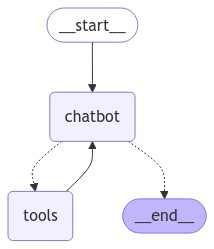

In [ ]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [ ]:
user_input="Who is bill gates, search on internet?"

events=graph.stream(
     {"messages": [("user", user_input)]},stream_mode="values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Who is bill gates, search on internet?
================================== Ai Message ==================================

A search on the internet reveals that Bill Gates is a:

**Business Magnate, Software Developer, and Philanthropist**

William Henry Gates III, commonly known as Bill Gates, was born on October 28, 1955, in Seattle, Washington, USA. He is best known for co-founding Microsoft Corporation, the world's largest software company, with Paul Allen.

**Early Life and Education**

Gates showed a keen interest in computer programming at a young age and began writing his own code when he was just 13 years old. He attended Lakeside School, an exclusive private school in Seattle, where he met his future business partner, Paul Allen. Gates scored 1590 out of 1600 on the SAT and enrolled at Harvard University in 1973, but he didn't stay for long. He dropped out two years later to focus on his fledgling

## https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration/#invoke

In [ ]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [ ]:
!pip install -qqq langchain_experimental

In [ ]:
from typing import Annotated

# from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()
@tool
def linkedin_post(text: str) -> str:
    """Use this tool when you need to update or post something on LinkedIn.

    Args:
        text (str): The content for the LinkedIn post. Generate this content by yourself if not provided.

    Returns:
        str: Status of the post operation.
    """
    return "linkedin post"



@tool
def chatbot(text: str) -> str:
    '''The LLM can provide an answer directly to the query.'''
    result = chain.invoke(
        {
            "input": text,
        }
    )
    return result.content

In [ ]:
import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict



# This defines the object that is passed between each node
# in the graph. We will create different nodes for each agent and tool
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [ ]:
import functools

from langchain_core.messages import AIMessage


# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }



# Research agent and node
decider = create_agent(
    llm,
    [search_on_internet,chatbot,linkedin_post],
    system_message="You should make a descion as to which tool must be used next.",
)
decider_node = functools.partial(agent_node, agent=decider, name="decider")


In [ ]:
from langgraph.prebuilt import ToolNode

tools = [search_on_internet, chatbot,linkedin_post]
tool_node = ToolNode(tools)

In [ ]:
# Either agent can decide to end
from typing import Literal


def router(state):
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END


In [ ]:
workflow = StateGraph(AgentState)

workflow.add_node("decider", decider_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "decider",
    router,
    {"call_tool": "call_tool", END: END},
)
workflow.add_edge(START, "decider")

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "decider": "decider",

    },
)

graph = workflow.compile()

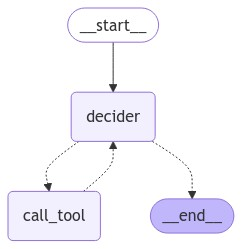

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name="llama3-8b-8192")

In [ ]:
events = graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Who is bill gates?"
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    s[list(s.keys())[0]]["messages"][-1].pretty_print()
    print("----")

================================== Ai Message ==================================
Name: decider
Tool Calls:
  search_on_internet (call_agnq)
 Call ID: call_agnq
  Args:
    query: Who is Bill Gates?
----
================================= Tool Message =================================
Name: search_on_internet

[{"title": "Bill Gates | Biography, Microsoft, & Facts | Britannica Money", "url": "https://www.britannica.com/money/Bill-Gates", "content": "Bill Gates (born October 28, 1955, Seattle, Washington, U.S.) is an American computer programmer and entrepreneur who cofounded Microsoft Corporation, the world's largest personal-computer software company.. Gates wrote his first software program at the age of 13. In high school he helped form a group of programmers who computerized their school's payroll system and founded Traf-O-Data, a ...", "score": 0.99621993, "raw_content": null}, {"title": "Bill Gates - Wikiwand", "url": "https://www.wikiwand.com/en/articles/Bill_Gates", "content": "Bi

## not important


In [ ]:
!pip install -U langsmith

In [ ]:
!pip install -qqq langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.2 MB/s eta 0:00:00


In [ ]:
!export LANGCHAIN_TRACING_V2=true
!export LANGCHAIN_API_KEY=""

In [ ]:
!export TAVILY_API_KEY="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"

In [ ]:
import getpass
import os

if "LANGCHAIN_API_KEY" not in os.environ:
    os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

Enter your Tavily API key: ··········


In [ ]:
import getpass
import os

if "LANGCHAIN_TRACING_V2" not in os.environ:
    os.environ["LANGCHAIN_TRACING_V2"] = getpass.getpass("Enter your Tavily API key: ")

Enter your Tavily API key: ··········


In [ ]:
import getpass
import os

if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter your Tavily API key: ")

Enter your Google AI API key: ··········
